# Data Analysis Intro 
30 May 2023 \
A. Baskind

# Import Python packages

Most of these packages are standard to Anaconda, and, if you don't have them, can install them easily with `conda install <package name>`. However, `PyCO2SYS` is a bit trickier to install.

To install `PyCO2SYS`, write in the command line `pip install PyCO2SYS`. You *may* need to first activate your conda environment

In [252]:
%pwd

'/Users/akbaskind/Documents/Python Scripts/phyto'

In [253]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

from importlib import reload
import warnings
warnings.filterwarnings('ignore')



I have also written a couple Python functions that help with data analysis. I implement them below.

The `%` essentially means run the line as if it were in the command line. `cd` directs the computer to the directory where the Python script is. `run` executes the script. Since the script is only a couple of functions, all this does is give you access to these functions.

In [255]:
%run PLT.py

# PLT functions
```Python
def get_hydrocat(start_date, end_date, buoy):
    """
    Retrieve Hydrocat data from Andy Davies' sensors using the API
    Drop 0 or negative pH values
    Convert pH from NBS to total scale using PyCO2SYS
        
    INPUTS:
    - start_date: date as a string, formatted as YYYY-MM-DD
    - end_date: date as a string, formatted as YYYY-MM-DD
    - buoy: Jamestown/620/PLT or 720/Greenwich Bay/BG
        
    RETURNS pandas DataFrame
        
    Add '%cd directory' and '%run PLT.py' to your script, making sure the path is correct
    """ 
```
```Python
def dic_to_uM(dic, S, T):
    """
    This function converts from units of umol/kg to uM [umol/L] by calculating density using an equation of state.
        
    INPUTS:
        - DIC or TA in umol/kg
        - Salinity in PSU
        - Temperature in degrees C
        
    OUTPUTS:
    - DIC or TA in uM
    """
```

Here, I demonstrate using a function from `PLT`.

In [25]:
PLT.dic_to_uM(2022.46, 33.464, 20.9)

2069.6911047255107

In [256]:
df = PLT.get_hydrocat('2022-01-01', '2022-12-30', 'PLT')
df

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
326,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 09:31:15.400000,7.934479
331,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 10:46:15.400000,7.934814
332,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 11:01:15.200000,7.934773
333,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 11:16:15.200000,7.934821
334,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 11:31:15.200000,7.924688
...,...,...,...,...,...,...,...,...,...,...,...
31734,2022-12-29T22:46:29.000Z,12/29/2022 22:45:00,3.9276,27.7203,10.546,29.3688,0.097,64.257,8.12,2022-12-29 22:46:29,8.016546
31735,2022-12-29T23:01:29.000Z,12/29/2022 23:00:00,3.9210,27.7232,10.552,29.3782,0.093,64.640,8.11,2022-12-29 23:01:29,8.006574
31736,2022-12-29T23:16:29.000Z,12/29/2022 23:15:00,3.9183,27.7297,10.567,29.3882,0.123,64.546,8.12,2022-12-29 23:16:29,8.016597
31737,2022-12-29T23:31:29.000Z,12/29/2022 23:30:00,3.9342,27.7421,10.652,29.3883,0.123,65.017,8.13,2022-12-29 23:31:29,8.026570


# Setting up API retrieval from Google Sheets

*Notably I set this API up with my google account. It took forever to figure so I am hoping you can just use my credentials. If they don't work, I'll have a tough task ahead of me haha.*

> Make sure to have installed the necessary packages in your conda environment
>>```
conda activate base
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
pip install gspread oauth2client df2gspread

> Have `credentials.json` in your working directory

> Have `servicecredentials.json` in your working directory

> Share your Google sheet with your service account: `google-sheets@third-faculty-385421.iam.gserviceaccount.com`

> Get spreadsheet key from your Google sheet and identify the worksheet you want

In [6]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Dataset 1: Lab Samples found [here](https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0)
This Google Sheet has on `Sheet1` all the relevant samples. It provides
* sample name
* location (PLT for time series site; GB for Greenwich Bay)
* date & time of collection
* surface or bottom
* temperature when TA was measured (degC)
* measured TA (uM)
* temperature when DIC was measured (degC)
* measured DIC (uM)
* salinity (PSU)

Since it is a working document, some cells are empty.

The other sheet in the Google Sheet (`Sample Log`) records all samples collected. It provides
* sample name
* location
* depth
* date and time
* completion of TA and DIC

This information is originally recorded in the lab notebook. I do my best to keep the sheet up-to-date, but it's not perfect.

## Retrieve lab samples from Google API

The `spreadsheet_key` can be founded in any sheet's url after '/d/' and before '/edit': https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.

The `wks_name` is the name of the individual sheet within the workbook. In this workbook, the options are Sheet1 and Sample Log. Since sample data is held on Sheet1, use that for `wks_name`.

In [268]:
spreadsheet_key = '17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U'
wks_name = 'Sheet1'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
labdata = pd.DataFrame(values[1:], columns = values[0])
labdata.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.47,22,1985.40452,29.42,NOTE: Salinity values are currently either der...
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.78,22,1955.71939,29.42,
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22,1931.63783,29.48,
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.41,22,1931.62999,29.48,
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22,1978.53868,30,


## Bit of data clean up

Since I have notes written in some of the columns, we will first select which columns we would like from the dataframe. I've also found that often when pulling from Google Sheets, all the data is written as strings, so here we also convert our data to appropriate data types.

In [278]:
df = labdata[['Sample', 'Time', 'Location', 'depth', 'TA Temp (degC)', 'TA (uM)',
       'DIC Temp (degC)', 'DIC (uM)', 'Salinity']]
df['TA (uM)'] = pd.to_numeric(df['TA (uM)'])
df['TA Temp (degC)'] = pd.to_numeric(df['TA Temp (degC)'])
df['DIC (uM)'] = pd.to_numeric(df['DIC (uM)'])
df['DIC Temp (degC)'] = pd.to_numeric(df['DIC Temp (degC)'])
df['Salinity'] = pd.to_numeric(df['Salinity'])
df["DateTime"] = pd.to_datetime(df["Time"])
df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 07:30:00
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 07:30:00
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 07:30:00
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 07:30:00
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 07:30:00


We also need to drop missing data.

In [279]:
daylight_start_date23 = pd.Timestamp(datetime(2023, 3, 12, 0, 0,0))
daylight_end_date23 = pd.Timestamp(datetime(2023, 11, 5, 0, 0,0))
daylight_start_date22 = pd.Timestamp(datetime(2022, 3, 13, 0, 0,0))
daylight_end_date22 = pd.Timestamp(datetime(2022, 11, 6, 0, 0,0))

# For each index in dataframe df...
for ind in df.index:
    if (df['DateTime'][ind] >= daylight_start_date23) & (df['DateTime'][ind] < daylight_end_date23):
        df['DateTime'][ind] = df['DateTime'][ind] + timedelta(hours = 4)
    elif (df['DateTime'][ind] >= daylight_start_date22) & (df['DateTime'][ind] < daylight_end_date22):
        df['DateTime'][ind] = df['DateTime'][ind] + timedelta(hours = 4)
    else:
        df['DateTime'][ind] = df['DateTime'][ind] + timedelta(hours = 5)
    # if TA or DIC at that index is Nan/empty...
    if math.isnan(df['TA (uM)'][ind]) or math.isnan(df['DIC (uM)'][ind]):
        # Drop that index
        df = df.drop(ind)

In [291]:
labGB = df.where(df['Location']== 'GB').dropna()
labPLT = df.where(df['Location']== 'PLT').dropna()

In [281]:
labGB

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime
5,GB B 9/9/22,9/9/22 11:30,GB,surface,21.3,1957.870,22.5,1883.0,29.08,2022-09-09 15:30:00
6,GB A 9/9/22,9/9/22 11:30,GB,surface,21.3,1955.840,22.5,1882.8,29.02,2022-09-09 15:30:00
7,GB B 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.600,22.5,1938.6,30.11,2022-09-20 15:30:00
8,GB A 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.930,22.5,1937.2,30.09,2022-09-20 15:30:00
9,GB A 10/25/22,10/25/22 11:30,GB,surface,21.3,2047.245,21.1,1931.6,29.41,2022-10-25 15:30:00
10,GB B 10/25/22,10/25/22 11:30,GB,surface,21.3,2043.310,21.1,1930.5,29.33,2022-10-25 15:30:00
11,GB A 11/9/22,11/9/22 11:30,GB,surface,21.3,2079.940,21.1,1964.5,29.93,2022-11-09 16:30:00
12,GB B 11/9/22,11/9/22 11:30,GB,surface,21.3,2080.755,21.1,1963.9,29.97,2022-11-09 16:30:00


## Unit conversion

Our lab equipment provides DIC and TA in uM (i.e. umol/l). However, units of umol/kg are more useful, and those are the units used by `PyCO2SYS`. So we must convert units.

$$ \frac{\text{umol}}{\text{L}} \times \frac{\text{L}}{0.001\ \text{m}^3} \times \frac{\text{m}^3}{\text{kg}} = \frac{\text{umol}}{\text{kg}}
$$

$$ \text{DIC} \times \frac{1}{0.001} \times \frac{1}{\rho} $$

I have been solving for density $\rho$ using the `gsw` python package. To install, you may need to install externally similar to how we installed `PyCO2SYS`. I've been using `gsw.density.rho(S, T, p)`, which returns in situ density. We have temperature and salinity already in our data, but we must provide pressure. To do this, I create a new column in our dataframe for pressure and say pressure is 0 everywhere, since these samples are being analyzed in the lab where pressure is only from the atmosphere (the function inherently accounts for atmospheric pressure). Notably, since TA and DIC are generalized measured on different days, we have to use different temperatures and thus different densities for both TA and DIC.

In [282]:
# Pressure
df['P'] = 0

# Density
df['rho_DIC'] = gsw.rho(df['Salinity'], df['DIC Temp (degC)'], df['P'])
df['rho_TA'] = gsw.rho(df['Salinity'], df['TA Temp (degC)'], df['P'])

# Converted DIC and TA
df['DIC (umol/kg)'] = df['DIC (uM)']/df['rho_DIC']/0.001
df['TA (umol/kg)'] = df['TA (uM)']/df['rho_TA']/0.001


df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg)
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 11:30:00,0,1019.934637,1020.378834,1946.599760,2034.019064
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 11:30:00,0,1019.934637,1020.378834,1917.494827,2035.302901
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 11:30:00,0,1019.979359,1020.269717,1893.800902,2037.524946
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 11:30:00,0,1019.979359,1020.269717,1893.793216,2037.118191
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 11:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077


## Calculate pH for lab data

To do this, we use `PyCO2SYS`. The documentation for how to use `PyCO2SYS` is [here](https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/).

In [283]:
results = pyco2.sys(par1=df['TA (umol/kg)'],par2=df['DIC (umol/kg)'],par1_type=1,par2_type=2,salinity = df['Salinity'], temperature = df['DIC Temp (degC)'])
df['pH'] = results['pH']
df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg),pH
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 11:30:00,0,1019.934637,1020.378834,1946.599760,2034.019064,7.708114
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 11:30:00,0,1019.934637,1020.378834,1917.494827,2035.302901,7.800762
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 11:30:00,0,1019.979359,1020.269717,1893.800902,2037.524946,7.872124
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 11:30:00,0,1019.979359,1020.269717,1893.793216,2037.118191,7.871104
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 11:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077,7.890143


# Dataset 2: SeaFET sensor data

The lab has had a couple issues deploying this sensor, so I have not added any recent SeaFET datasets to the shared drive

In [284]:
pH_data = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/pH.csv')
pH_data.drop(pH_data.tail(6).index,inplace=True)

In [285]:
pH_data["DateTime"] = pd.to_datetime(pH_data["DateTime (UTC-04:00)"])

In [286]:
pH_data

,FrameSync,DateTime (UTC-04:00),Sample Number (#),Error Flags (#),Temperature (Celsius),External pH (pH),Internal pH (pH),External pH (Volt),Internal pH (Volt),pH Temperature (Celsius),Pressure (Decibar),Salinity (psu),Conductivity (S/m),Oxygen (ml/L),Relative Humidity (%),Int Temperature (Celsius),Time,DateTime
0,SSPHOX02346,9/9/22 21:00,1,0,23.0835,7.7486,7.7211,-0.909148,-0.962519,22.9960,0.390,28.9213,4.30743,4.743,0.8,22.8,21:00:01,2022-09-09 21:00:00
1,SSPHOX02346,9/9/22 21:15,2,0,22.9676,7.7456,7.7146,-0.909641,-0.962943,22.9116,0.400,29.1746,4.33104,4.643,0.8,22.8,21:15:01,2022-09-09 21:15:00
2,SSPHOX02346,9/9/22 21:30,3,0,23.0644,7.7556,7.7256,-0.908880,-0.962263,22.9848,0.414,29.0708,4.32571,4.757,0.9,22.9,21:30:01,2022-09-09 21:30:00
3,SSPHOX02346,9/9/22 21:45,4,0,23.1619,7.7569,7.7270,-0.908768,-0.962145,23.0272,0.407,29.1291,4.34210,4.827,0.9,23.0,21:45:01,2022-09-09 21:45:00
4,SSPHOX02346,9/9/22 22:00,5,0,23.0252,7.7719,7.7369,-0.908272,-0.961610,23.0860,0.443,29.4415,4.37166,4.917,0.9,23.0,22:00:01,2022-09-09 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,SSPHOX02346,11/9/22 14:15,5830,0,14.3627,7.8973,7.8456,-0.908945,-0.958658,14.3767,0.611,30.1214,3.69639,5.457,0.0,14.4,14:15:01,2022-11-09 14:15:00
5830,SSPHOX02346,11/9/22 14:30,5831,0,14.3665,7.9010,7.8501,-0.908691,-0.958398,14.3710,0.611,30.0739,3.69146,5.469,0.0,14.4,14:30:01,2022-11-09 14:30:00
5831,SSPHOX02346,11/9/22 14:45,5832,0,14.3851,7.8829,7.8330,-0.909664,-0.959363,14.3843,0.614,30.0213,3.68724,5.475,0.0,14.4,14:45:01,2022-11-09 14:45:00
5832,SSPHOX02346,11/9/22 15:00,5833,0,14.4654,7.8734,7.8308,-0.910005,-0.959457,14.4306,0.615,29.8676,3.67711,5.482,0.0,14.4,15:00:01,2022-11-09 15:00:00


Text(0.5, 0, 'Year-Month')

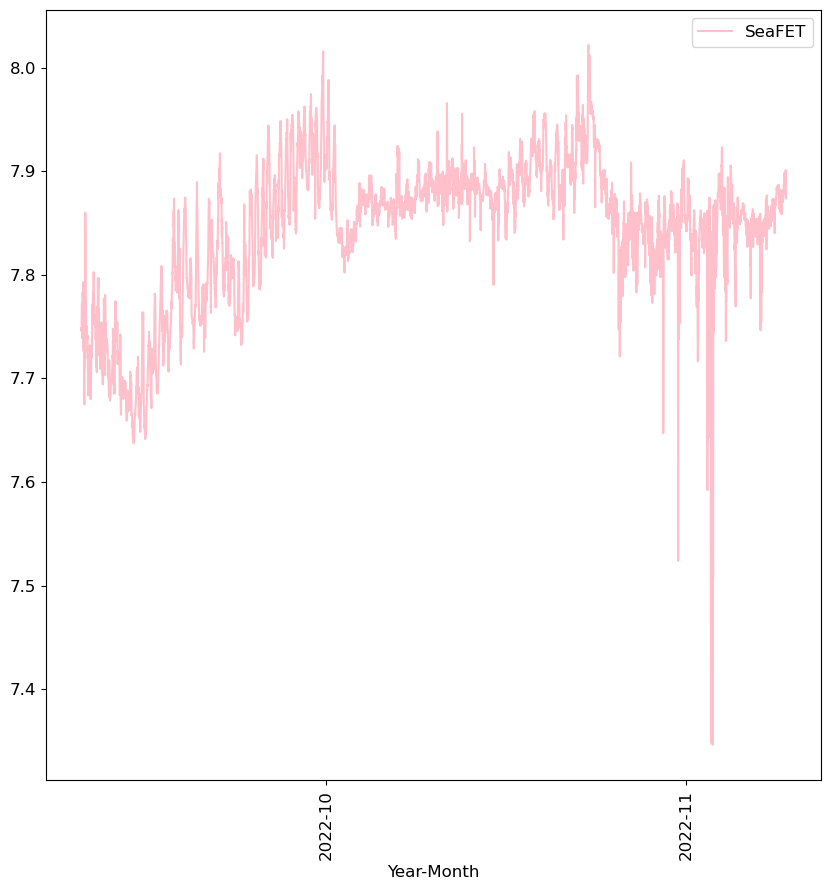

In [287]:
fig,ax = plt.subplots(figsize=[10,10])
ax.plot(pH_data['DateTime'].to_numpy(), pH_data['External pH (pH)'].to_numpy(), color = 'pink', label = 'SeaFET')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

# Dataset 3: Hydrocat sensors from the Davies Lab

Note: pH from these sensors are in NBS scale. We used total scale. The function `PLT.get_hydrocat(start_date, end_date, site)` does that conversion for you.

In [288]:
andy = PLT.get_hydrocat('2022-01-01', '2023-06-07', 'PLT')
andy

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
326,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 09:31:15.400000,7.934479
331,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 10:46:15.400000,7.934814
332,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 11:01:15.200000,7.934773
333,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 11:16:15.200000,7.934821
334,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 11:31:15.200000,7.924688
...,...,...,...,...,...,...,...,...,...,...,...
46995,2023-06-06T22:46:29.000Z,06/06/2023 22:45:00,16.3779,37.4033,7.494,28.9958,0.007,19.400,8.66,2023-06-06 22:46:29,8.533749
46996,2023-06-06T23:01:29.000Z,06/06/2023 23:00:00,16.3461,37.3693,7.508,28.9896,0.006,19.625,8.65,2023-06-06 23:01:29,8.523799
46997,2023-06-06T23:16:29.000Z,06/06/2023 23:15:00,16.3289,37.3464,7.494,28.9823,0.005,19.891,8.53,2023-06-06 23:16:29,8.403822
46998,2023-06-06T23:31:29.000Z,06/06/2023 23:30:00,16.3370,37.3471,7.424,28.9770,0.005,19.804,8.59,2023-06-06 23:31:29,8.463800


Text(0.5, 0, 'Year-Month')

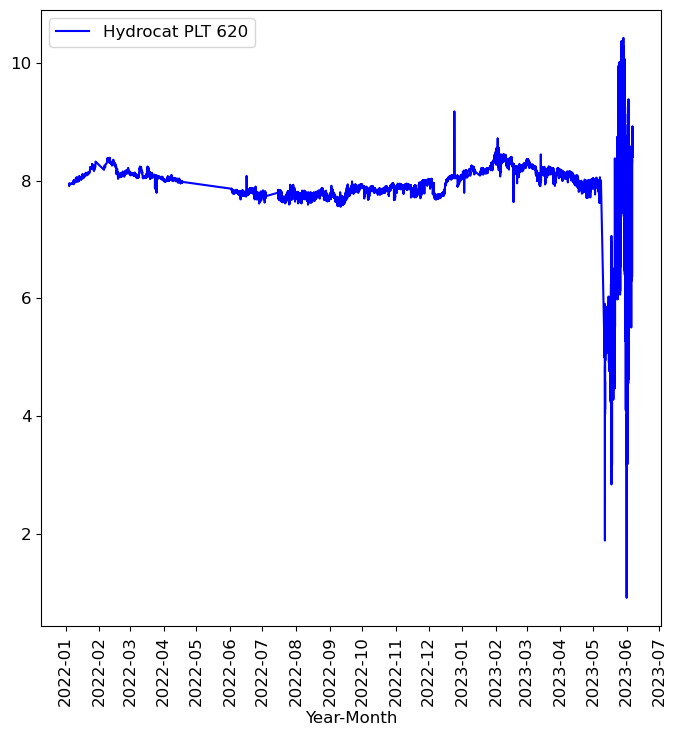

In [72]:
fig,ax = plt.subplots(figsize=[8,8])
ax.plot(andy['DateTime'], andy['pH total'], color = 'blue', label = 'Hydrocat PLT 620')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

In [289]:
andyGB = PLT.get_hydrocat('2022-01-01', '2023-06-07', 'GB')

Text(0.5, 0, 'Year-Month')

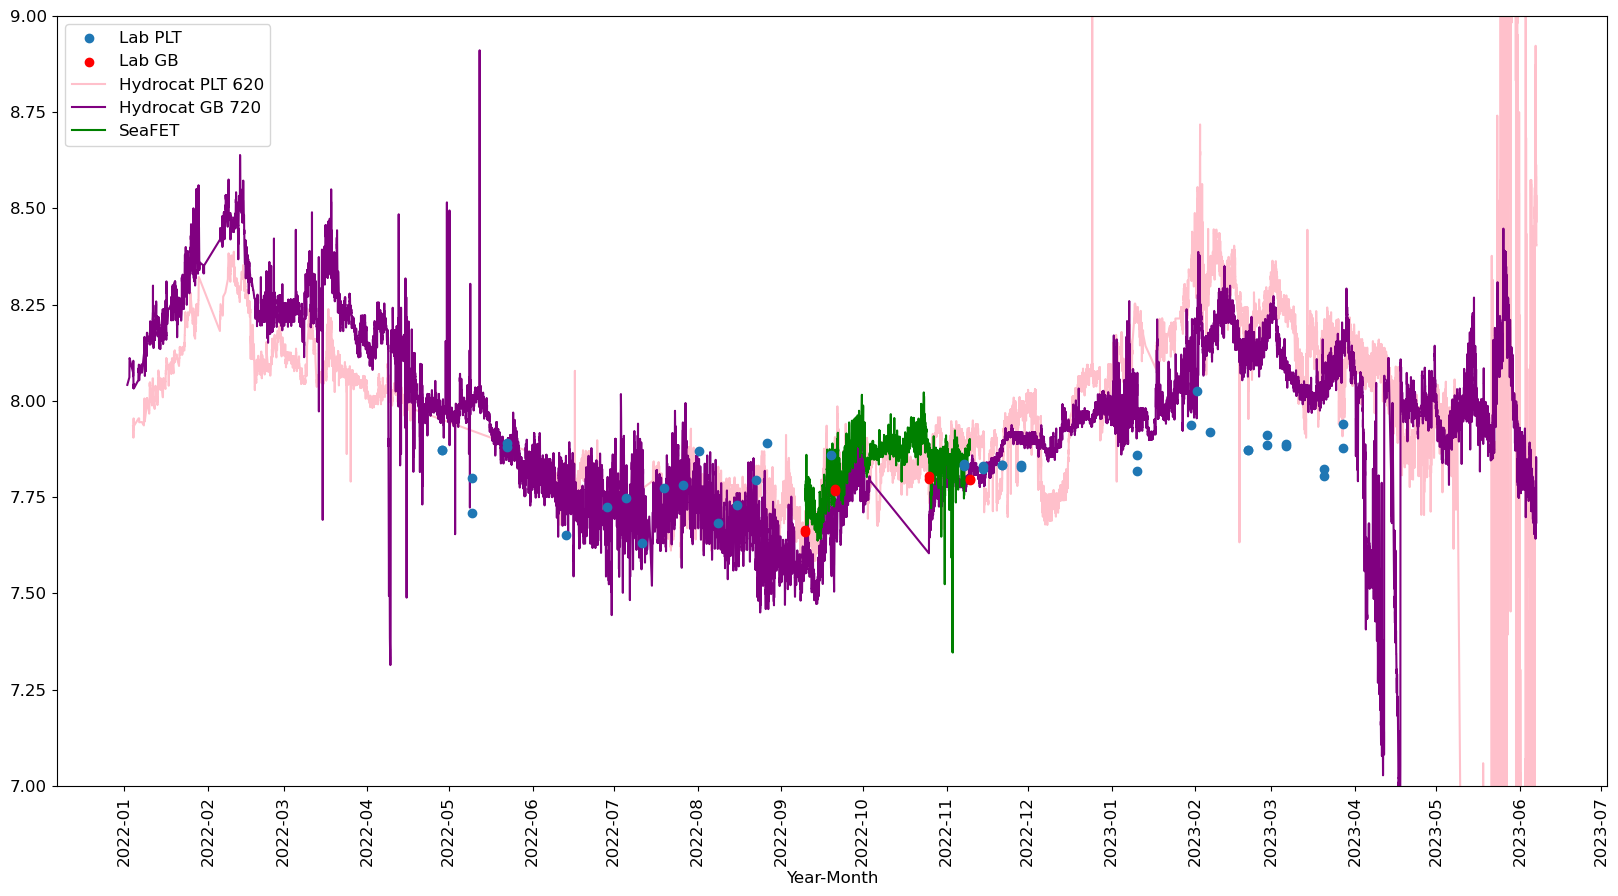

In [292]:
fig,ax = plt.subplots(figsize=[20,10])
ax.scatter(labPLT['DateTime'], labPLT['pH'], label = 'Lab PLT', zorder = 3)
ax.scatter(labGB['DateTime'], labGB['pH'], color = 'red',label = 'Lab GB', zorder = 3)
ax.plot(andy['DateTime'], andy['pH total'], color = 'pink', label = 'Hydrocat PLT 620')
ax.plot(andyGB['DateTime'], andyGB['pH total'], color = 'purple', label = 'Hydrocat GB 720')
ax.plot(pH_data['DateTime'], pH_data['External pH (pH)'], color = 'green', label = 'SeaFET')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_ylim([7,9])
ax.set_xlabel('Year-Month', fontsize = 12)

# Dataset 4: Narragansett Bay Fixed Station Monitoring Network sites

We have selected 2 sites from NBFSMN: QP and MV. QP is closer to the PLT lab samples and the Jamestown/PLT/Buoy 620 sensor. MV is closer to the GB and the GB/Buoy 720 sensor. The data on these spreadsheets [[MV](https://docs.google.com/spreadsheets/d/1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE/edit#gid=813729054), [QP](https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657)] is from the summer of 2022, as the NBFSMN only collects measurements in the summer. 

## MV
### Retrieving data through API

In [87]:
spreadsheet_key_MV = '1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE'
wks_name_MV = 'MV'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key_MV)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name_MV)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
MVdata = pd.DataFrame(values[3:], columns = values[1])
MVdata.head()

,Site,Agency,Date,Time,C,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,...,,,,,,,,,,
0,B6-S,gsovs,05/01/22,0:00,5/1/22 0:00,,,,,,...,,,,,,,,,,
1,B6-S,gsovs,05/01/22,0:15,5/1/22 0:15,,,,,,...,,,,,,,,,,
2,B6-S,gsovs,05/01/22,0:30,5/1/22 0:30,,,,,,...,,,,,,,,,,
3,B6-S,gsovs,05/01/22,0:45,5/1/22 0:45,,,,,,...,,,,,,,,,,
4,B6-S,gsovs,05/01/22,1:00,5/1/22 1:00,,,,,,...,,,,,,,,,,


### Subset the data
NSFSMN sites record surface and bottom data. For now, I am just selecting the surface data in columns 0 through 15, rename some of the columns, and drop some of the unnecessary columns

* `'Site'` -- dropped since they are all from the same site
* `'Agency '` -- dropped since they are all from the same agency
* `'Date '` 
* `'Time'` 
* `'C'` -- renamed `DateTime` since it combines `Date` and `Time`
* `'surface Temp'` 
* `'surface SpC'`
* `'surface Salinity'` 
* `'surface DO%'` 
* `'surface DO Conc'` 
* `'Depth'`
* `'surface pH'` 
* `'surface pH (mV)'` 
* `'surface Chl'` 
* `'surface FS'` -- dropped because I don't know what it is

In [117]:
surfaceMV = MVdata.iloc[:, 0:15]
surfaceMV = surfaceMV.drop(columns=['Site', "Agency ", 'surface FS'])
surfaceMV = surfaceMV.rename(columns={"C": "DateTime", 'Date ': 'Date'})
surfaceMV

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl
0,05/01/22,0:00,5/1/22 0:00,,,,,,,,,
1,05/01/22,0:15,5/1/22 0:15,,,,,,,,,
2,05/01/22,0:30,5/1/22 0:30,,,,,,,,,
3,05/01/22,0:45,5/1/22 0:45,,,,,,,,,
4,05/01/22,1:00,5/1/22 1:00,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
19771,11/22/22,22:45,11/22/22 22:45,,,,,,,,,
19772,11/22/22,23:00,11/22/22 23:00,,,,,,,,,
19773,11/22/22,23:15,11/22/22 23:15,,,,,,,,,
19774,11/22/22,23:30,11/22/22 23:30,,,,,,,,,


### Correct data types

For some reason, when pulling data from the spreadsheet, everything is pulled as type string. For example:
```python
IN: type(surfaceMV['surface Salinity'][0])

OUT: str
```

So we are going to change the data types of everything

**Note**: I have not confirmed what time zone out dates/times are in

In [122]:
for key in surfaceMV.keys():
    if key == 'DateTime' or key == 'Date' or key == 'Time':
        surfaceMV[key] = pd.to_datetime(surfaceMV[key])
    else:
        surfaceMV[key] = pd.to_numeric(surfaceMV[key])

### Drop rows with empty or `Nan` values and reset index values so indices go up from 0

In [125]:
for ind in surfaceMV.index:
    if math.isnan(surfaceMV['surface pH'][ind]):
        surfaceMV = surfaceMV.drop(ind)
surfaceMV = surfaceMV.reset_index(drop=True)
surfaceMV

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl
0,2022-05-25,2023-06-09 12:15:00,2022-05-25 12:15:00,18.498,45164.1,29.29,108.3,8.52,1.043,7.91,-89.3,1.6
1,2022-05-25,2023-06-09 12:30:00,2022-05-25 12:30:00,18.452,45257.7,29.36,106.9,8.42,1.045,7.90,-88.8,1.4
2,2022-05-25,2023-06-09 12:45:00,2022-05-25 12:45:00,18.399,45304.7,29.39,108.1,8.52,1.056,7.91,-89.6,1.7
3,2022-05-25,2023-06-09 13:00:00,2022-05-25 13:00:00,18.376,45345.2,29.42,107.8,8.50,1.051,7.92,-89.8,1.6
4,2022-05-25,2023-06-09 13:15:00,2022-05-25 13:15:00,18.230,45431.0,29.48,107.5,8.49,1.040,7.91,-89.7,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
16505,2022-11-22,2023-06-09 10:30:00,2022-11-22 10:30:00,8.814,46579.1,29.99,95.4,9.09,0.925,8.02,-90.9,1.5
16506,2022-11-22,2023-06-09 10:45:00,2022-11-22 10:45:00,8.680,46538.9,29.95,96.1,9.19,0.923,8.03,-91.3,1.7
16507,2022-11-22,2023-06-09 11:00:00,2022-11-22 11:00:00,8.646,46527.2,29.94,96.3,9.21,0.921,8.03,-91.4,1.9
16508,2022-11-22,2023-06-09 11:15:00,2022-11-22 11:15:00,8.582,46492.0,29.91,96.3,9.23,0.919,8.03,-91.6,2.0


### Convert pH from NBS scale to total scale using PyCO2SYS
NBFSMN measures pH in NBS scale (like Andy Davies' buoys) but we generally use total scale pH. We can use PyCO2SYS to convert from NBS to total scale.
```python
results = pyco2.sys(par1=pH, par1_type=3, temperature = temp, salinity = S, opt_pH_scale = 4)
```

Usually when using PyCO2SYS, we need 2 carbonate system inputs, but since we only are converting pH, we only need 1 pH input. So `par1` is our pH input. We specify through `par1_type = 3` that this input is pH. We also define `temperature` and `salinity` through a couple key word arguments. Finally, `opt_pH_scale` is the key word argument that specifices what scale our pH input is in. The default is total scale. Our input in NBS which is type `4`. You can look up the different scales through the [PyCO2SYS documentation](https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/), but I have also pasted the types below.

`1`: Total, i.e. $\text{pH}=−\log_{10}([H+]+[HSO^{−}_{4}])$
(default).

`2`: Seawater, i.e. $\text{pH}=−\log_{10}([H+]+[HSO^{−}_{4}]+[HF]$).

`3`: Free, i.e. $\text{pH}=−\log_{10}([H+])$.

`4`: NBS, i.e. relative to NBS/NIST reference standards.

In [127]:
resultsMV = pyco2.sys(par1=surfaceMV['surface pH'], par1_type=3, temperature = surfaceMV['surface Temp'], salinity = surfaceMV['surface Salinity'],opt_pH_scale = 4)
surfaceMV['pH total'] = resultsMV['pH_total']
surfaceMV

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl,pH total
0,2022-05-25,2023-06-09 12:15:00,2022-05-25 12:15:00,18.498,45164.1,29.29,108.3,8.52,1.043,7.91,-89.3,1.6,7.780182
1,2022-05-25,2023-06-09 12:30:00,2022-05-25 12:30:00,18.452,45257.7,29.36,106.9,8.42,1.045,7.90,-88.8,1.4,7.770350
2,2022-05-25,2023-06-09 12:45:00,2022-05-25 12:45:00,18.399,45304.7,29.39,108.1,8.52,1.056,7.91,-89.6,1.7,7.780484
3,2022-05-25,2023-06-09 13:00:00,2022-05-25 13:00:00,18.376,45345.2,29.42,107.8,8.50,1.051,7.92,-89.8,1.6,7.790562
4,2022-05-25,2023-06-09 13:15:00,2022-05-25 13:15:00,18.230,45431.0,29.48,107.5,8.49,1.040,7.91,-89.7,1.9,7.780906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16505,2022-11-22,2023-06-09 10:30:00,2022-11-22 10:30:00,8.814,46579.1,29.99,95.4,9.09,0.925,8.02,-90.9,1.5,7.908946
16506,2022-11-22,2023-06-09 10:45:00,2022-11-22 10:45:00,8.680,46538.9,29.95,96.1,9.19,0.923,8.03,-91.3,1.7,7.919123
16507,2022-11-22,2023-06-09 11:00:00,2022-11-22 11:00:00,8.646,46527.2,29.94,96.3,9.21,0.921,8.03,-91.4,1.9,7.919168
16508,2022-11-22,2023-06-09 11:15:00,2022-11-22 11:15:00,8.582,46492.0,29.91,96.3,9.23,0.919,8.03,-91.6,2.0,7.919234


### Preliminary plots of MV data

I wanted to make all the plots different colors so I created an array of HEX color codes (`clrs`) so each plot has its own color. There are probably other/better ways to do this.

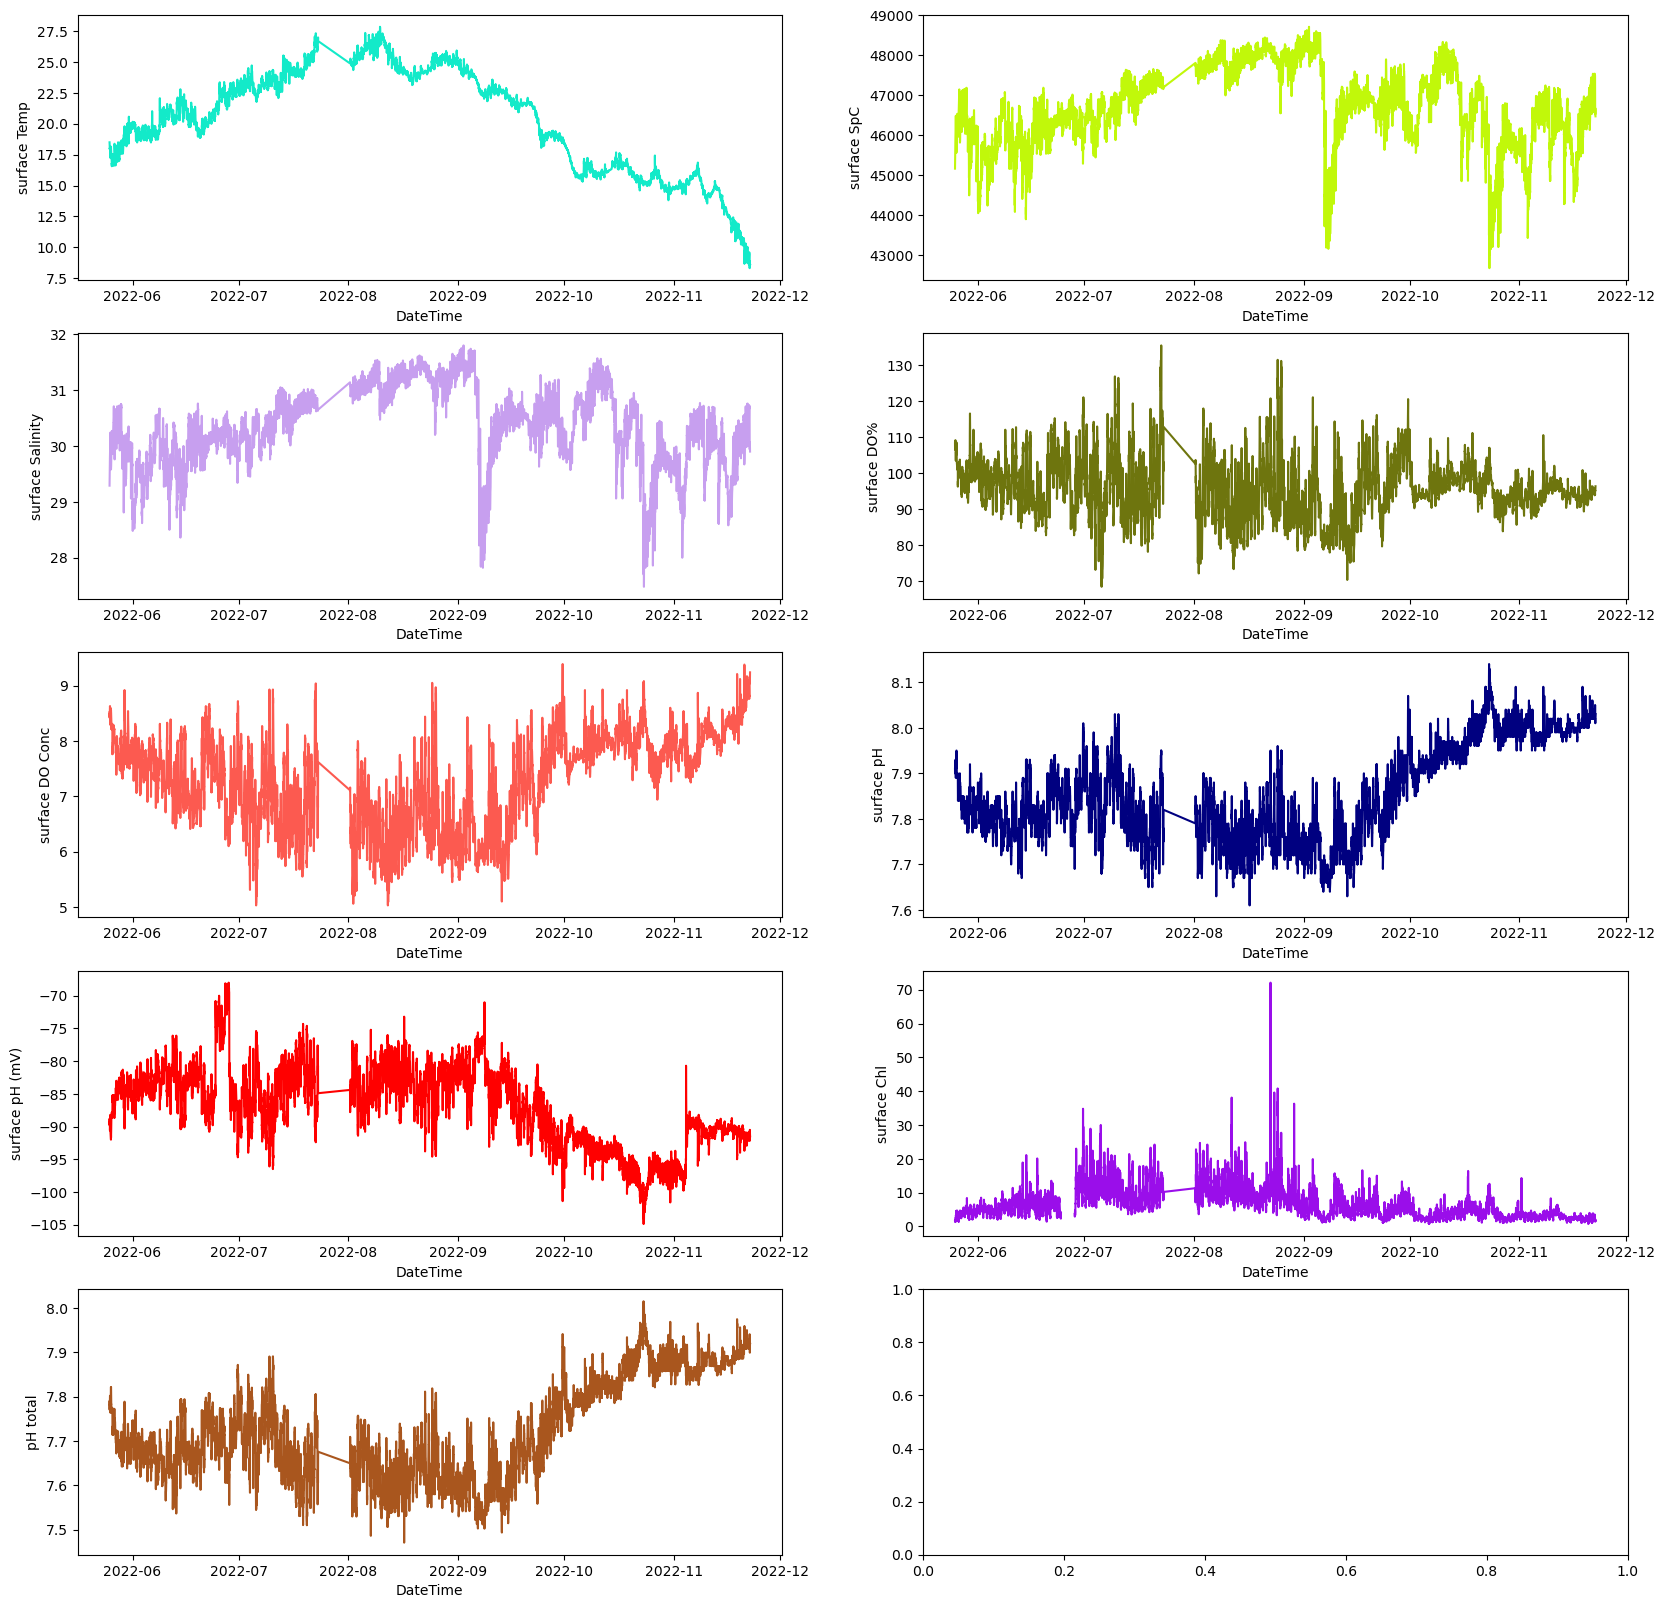

In [143]:
fig, axarr = plt.subplots(nrows = 5, ncols = 2, figsize = [20,20])

# color HEX code array
clrs = ['#13EAC9', '#C1F80A', '#C79FEF', '#6E750E', '#FC5A50', '#000080', '#FF0000', '#9A0EEA', '#A9561E', '#FAC205']
# an ID number that indexes through axes and also through the colors
ax_idx = 0
for key in surfaceMV.keys():
    ax = axarr.flat[ax_idx]
    
    # IF statement so that we only plot columns that are not silly things like date/time or depth
    if not key == 'Date' and not key == 'Time' and not key == 'DateTime' and not key == 'Depth':
        ax.plot(surfaceMV['DateTime'], surfaceMV[key], color = clrs[ax_idx])
        ax.set_xlabel('DateTime')
        ax.set_ylabel(key)
        ax_idx += 1

## QP
### Retrieve data through API

In [166]:
spreadsheet_key_QP = '1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw'
wks_name_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key_QP)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name_QP)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
QPdata = pd.DataFrame(values[3:], columns = values[1])
QPdata.head()

,Site,Agency,Date,Time,C,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,...,,,,,,,,,,
0,B7-S,gsoqs,05/01/22,0:00,5/1/22 0:00,,,,,,...,,,,,,,,,,
1,B7-S,gsoqs,05/01/22,0:15,5/1/22 0:15,,,,,,...,,,,,,,,,,
2,B7-S,gsoqs,05/01/22,0:30,5/1/22 0:30,,,,,,...,,,,,,,,,,
3,B7-S,gsoqs,05/01/22,0:45,5/1/22 0:45,,,,,,...,,,,,,,,,,
4,B7-S,gsoqs,05/01/22,1:00,5/1/22 1:00,,,,,,...,,,,,,,,,,


### Subset the data

In [167]:
surfaceQP = QPdata.iloc[:, 0:15]
surfaceQP = surfaceQP.drop(columns=['Site', "Agency ", 'surface FS'])
surfaceQP = surfaceQP.rename(columns={"C": "DateTime", 'Date ': 'Date'})
surfaceQP

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl
0,05/01/22,0:00,5/1/22 0:00,,,,,,,,,
1,05/01/22,0:15,5/1/22 0:15,,,,,,,,,
2,05/01/22,0:30,5/1/22 0:30,,,,,,,,,
3,05/01/22,0:45,5/1/22 0:45,,,,,,,,,
4,05/01/22,1:00,5/1/22 1:00,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
19771,11/22/22,22:45,11/22/22 22:45,,,,,,,,,
19772,11/22/22,23:00,11/22/22 23:00,,,,,,,,,
19773,11/22/22,23:15,11/22/22 23:15,,,,,,,,,
19774,11/22/22,23:30,11/22/22 23:30,,,,,,,,,


### Correct the data types

In [168]:
for key in surfaceQP.keys():
    if key == 'DateTime' or key == 'Date' or key == 'Time':
        surfaceQP[key] = pd.to_datetime(surfaceQP[key])
    else:
        surfaceQP[key] = pd.to_numeric(surfaceQP[key])

### Drop empty rows and reindex

In [169]:
for ind in surfaceQP.index:
    if math.isnan(surfaceQP['surface pH'][ind]):
        surfaceQP = surfaceQP.drop(ind)
surfaceQP = surfaceQP.reset_index(drop=True)
surfaceQP

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl
0,2022-05-25,2023-06-13 08:00:00,2022-05-25 08:00:00,16.35,47.14,30.70,100.928,8.208,0.969,8.06,-73.0,1.1
1,2022-05-25,2023-06-13 08:15:00,2022-05-25 08:15:00,16.44,47.14,30.71,101.280,8.223,0.945,8.06,-73.2,2.0
2,2022-05-25,2023-06-13 08:30:00,2022-05-25 08:30:00,16.35,47.18,30.73,101.221,8.230,0.953,8.06,-73.1,1.1
3,2022-05-25,2023-06-13 08:45:00,2022-05-25 08:45:00,16.58,47.09,30.67,101.599,8.227,0.954,8.06,-73.1,2.0
4,2022-05-25,2023-06-13 09:00:00,2022-05-25 09:00:00,16.56,47.12,30.69,101.574,8.227,0.953,8.06,-73.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
17382,2022-11-22,2023-06-13 09:30:00,2022-11-22 09:30:00,9.66,44.97,28.91,95.313,9.011,1.016,8.27,-74.5,2.4
17383,2022-11-22,2023-06-13 09:45:00,2022-11-22 09:45:00,9.64,45.02,28.95,95.943,9.073,1.020,8.27,-74.4,1.1
17384,2022-11-22,2023-06-13 10:00:00,2022-11-22 10:00:00,9.66,44.33,28.46,95.422,9.049,1.018,8.27,-74.5,2.9
17385,2022-11-22,2023-06-13 10:15:00,2022-11-22 10:15:00,9.67,44.15,28.33,95.775,9.087,1.013,8.26,-74.3,1.4


### Convert pH scale

In [170]:
resultsQP = pyco2.sys(par1=surfaceQP['surface pH'], par1_type=3, temperature = surfaceQP['surface Temp'], salinity = surfaceQP['surface Salinity'],opt_pH_scale = 4)
surfaceQP['pH total'] = resultsQP['pH_total']
surfaceQP

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl,pH total
0,2022-05-25,2023-06-13 08:00:00,2022-05-25 08:00:00,16.35,47.14,30.70,100.928,8.208,0.969,8.06,-73.0,1.1,7.935983
1,2022-05-25,2023-06-13 08:15:00,2022-05-25 08:15:00,16.44,47.14,30.71,101.280,8.223,0.945,8.06,-73.2,2.0,7.935824
2,2022-05-25,2023-06-13 08:30:00,2022-05-25 08:30:00,16.35,47.18,30.73,101.221,8.230,0.953,8.06,-73.1,1.1,7.936022
3,2022-05-25,2023-06-13 08:45:00,2022-05-25 08:45:00,16.58,47.09,30.67,101.599,8.227,0.954,8.06,-73.1,2.0,7.935504
4,2022-05-25,2023-06-13 09:00:00,2022-05-25 09:00:00,16.56,47.12,30.69,101.574,8.227,0.953,8.06,-73.0,1.6,7.935568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17382,2022-11-22,2023-06-13 09:30:00,2022-11-22 09:30:00,9.66,44.97,28.91,95.313,9.011,1.016,8.27,-74.5,2.4,8.155723
17383,2022-11-22,2023-06-13 09:45:00,2022-11-22 09:45:00,9.64,45.02,28.95,95.943,9.073,1.020,8.27,-74.4,1.1,8.155820
17384,2022-11-22,2023-06-13 10:00:00,2022-11-22 10:00:00,9.66,44.33,28.46,95.422,9.049,1.018,8.27,-74.5,2.9,8.155032
17385,2022-11-22,2023-06-13 10:15:00,2022-11-22 10:15:00,9.67,44.15,28.33,95.775,9.087,1.013,8.26,-74.3,1.4,8.144817


# Quality Assurance/Quality Control

So now we have all our datasets

* Lab data for PLT: `labPLT`

* Lab data for GB: `labGB`

* SeaFET sensor data: `pH_data`

* Hydrocat #620: `andy`

* Hydrocat #720: `andyGB`

* NBFSMN MV: `surfaceMV`

* NBFSMN QP: `surfaceQP`

We can be **very** confident that our lab samples are correct. Ultimately, everything needs to agree with the lab samples, since those are the gold standard.

However, we have some degree of confidence in our other datasets. We have a medium amount of confidence in the SeaFET data we have now, since this sensor is high precision and when it was deployed it had just been calibrated. If we were to deploy that sensor today, though, we would have less confidence in it since it has not been calibrated in over a year. Further, this sensor is still susceptible to biofouling, which can really disrupt our measurements, but since I have had this dataset for several months, I am sure it has no evidence of biofouling as it is. We can verify that based on how closely it tracks with lab samples.

We also have a medium amount of confidence in the NBFSMN data for 2 reasons: 1.) When the sensors are deployed, they are very reliably serviced/cleaned every couple of weeks and, 2.) these datasets have already gone through preliminary QA/QC to remove huge outliers. This is to say, we can be confident that the data present are actually representative of conditions, rather than biofouling or other sensor failure. However, this does not exclude a persistent bias in the dataset because these datasets have not been compared to external datasets; they have only been compared to themselves.

Finally, we have so little confidence in the Hydrocat sensors. The primary use of these sensors in the Davies lab is not for pH, so they do not reliably calibrate the pH sensor. Further, the Davies lab is responsible for field maintenance of the sensors. Their ability to maintain the sensors once deployed depends on whether they have a trained diver employed and on whether conditions are safe for diving. For instance, we know this winter, the sensors went many, many weeks without any maintenance because it was too cold/windy/stormy for divers to safely go out into the field and clean the sensors in the water. Thus, during this time, the sensors experienced severe biofouling. I hypothesize that the winter data is trash for this reason.

## Note on time zone conversion

I realized today (June 13) that the way I have adjusted time zones in this data is not robust. The sensors typically measure in UTC time, which does not obey daylights savings. The lab data, however, does obey daylights savings. This is to say, some of the data may be displaced by 1 hour during daylights savings time.

I need to adjust how I correct for time zone differences in the future. Dave Ullman suggested I keep what is in UTC in UTC and convert lab data to UTC time. I agree with this solution but as of right now this change has not been made. **UPDATE** I DID CORRECT THE TIMEZONES. The change includes an update to `PLT.py` so make sure to update that.

In [293]:
for ind in andy.index:
    if andy['pH total'][ind] > 9:
        andy = andy.drop(ind)
    elif andy['pH total'][ind] < 6:
        andy = andy.drop(ind)
andy = andy.reset_index(drop=True)
andy

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
0,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 09:31:15.400000,7.934479
1,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 10:46:15.400000,7.934814
2,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 11:01:15.200000,7.934773
3,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 11:16:15.200000,7.934821
4,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 11:31:15.200000,7.924688
...,...,...,...,...,...,...,...,...,...,...,...
36277,2023-06-06T22:46:29.000Z,06/06/2023 22:45:00,16.3779,37.4033,7.494,28.9958,0.007,19.400,8.66,2023-06-06 22:46:29,8.533749
36278,2023-06-06T23:01:29.000Z,06/06/2023 23:00:00,16.3461,37.3693,7.508,28.9896,0.006,19.625,8.65,2023-06-06 23:01:29,8.523799
36279,2023-06-06T23:16:29.000Z,06/06/2023 23:15:00,16.3289,37.3464,7.494,28.9823,0.005,19.891,8.53,2023-06-06 23:16:29,8.403822
36280,2023-06-06T23:31:29.000Z,06/06/2023 23:30:00,16.3370,37.3471,7.424,28.9770,0.005,19.804,8.59,2023-06-06 23:31:29,8.463800


Text(0.5, 0, 'Year-Month')

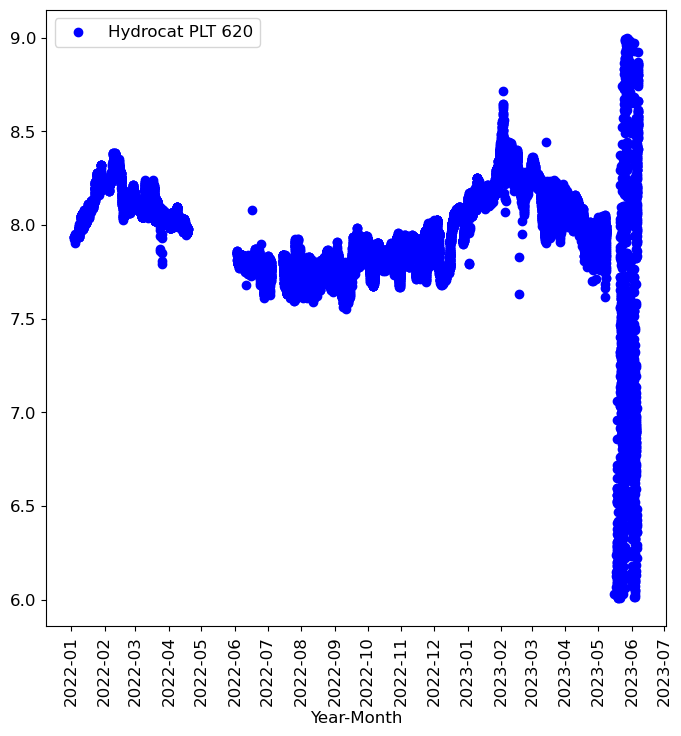

In [162]:
fig,ax = plt.subplots(figsize=[8,8])
ax.scatter(andy['DateTime'], andy['pH total'], color = 'blue', label = 'Hydrocat PLT 620')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

## Linear regression of oxygen and pH to check NBFSMN MV

* I'm using `sklearn.LinearRegression` as informed by [this website](https://realpython.com/linear-regression-in-python/)

In [299]:
from sklearn.linear_model import LinearRegression
# LinearRegression requires reshaping of the data so this converts the pandas series to 
# a numpy array and then reshapes
x = surfaceMV['surface DO Conc'].to_numpy().reshape(-1, 1)
y = surfaceMV['pH total'].to_numpy().reshape(-1, 1)
model = LinearRegression().fit(x, y)

# this line predicts y (i.e. pH) based on the input x (i.e. dissolved oxygen)
# in other words, these are the y values of the linear model
y_pred = model.predict(x)

In [300]:
y_pred

array([[7.8685693 ],
       [7.85692699],
       [7.8685693 ],
       ...,
       [7.94890125],
       [7.95122971],
       [7.95239394]])

In [205]:
# I just created a new dataset in case I screw anything up
SURFACEMV = surfaceMV
# added the predicted pH to the new dataset
SURFACEMV['y_pred'] = y_pred
# added the difference between the predicted pH and the actual pH
SURFACEMV['y - y_pred'] = y - y_pred
# selecting the part of the dataset where the diff between predicted and actual is greater than 2 stds
SURFACEMV.where(np.abs(SURFACEMV['y - y_pred']) > 2*surfaceMV['pH total'].std()).dropna()

,Date,Time,DateTime,surface Temp,surface SpC,surface Salinity,surface DO%,surface DO Conc,Depth,surface pH,surface pH (mV),surface Chl,pH total,y_pred,y - y_pred


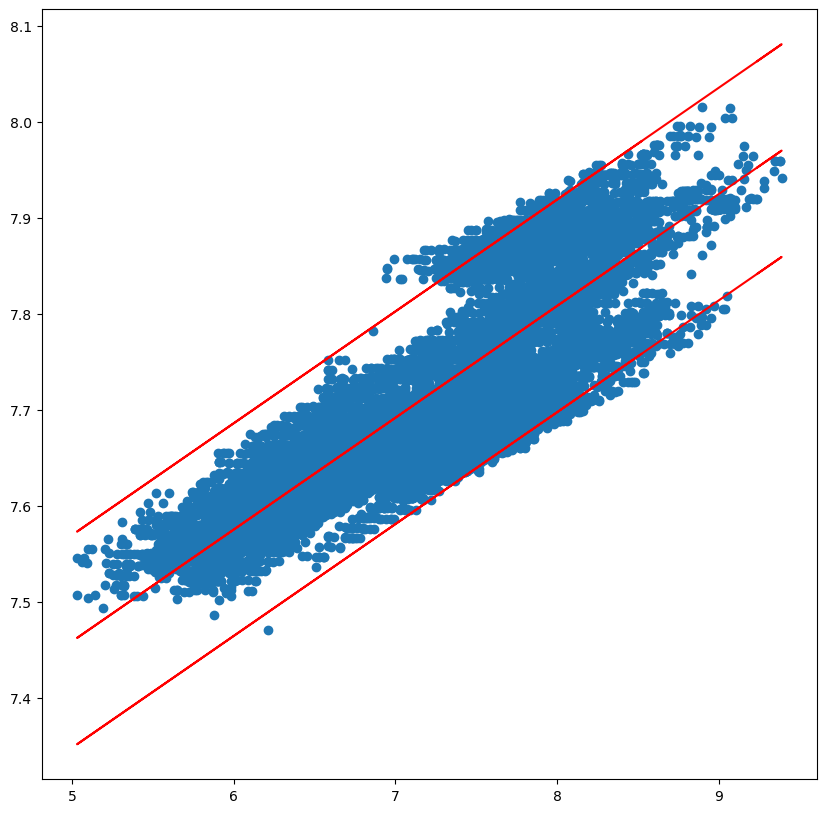

In [301]:
fig, ax = plt.subplots(figsize = [10,10])

# plot x: x = surfaceMV['surface DO Conc'].to_numpy().reshape(-1, 1)
# by y  : y = surfaceMV['pH total'].to_numpy().reshape(-1, 1)
ax.scatter(x,y)
# x by the predicted y
ax.plot(x,y_pred, color = 'red')
# add eerror lines
ax.plot(x,y_pred - surfaceMV['pH total'].std(), color = 'red')
ax.plot(x,y_pred + surfaceMV['pH total'].std(), color = 'red')
# ax.fill_between(surfaceMV['surface DO Conc'], SURFACEMV['y_pred'],SURFACEMV['y_pred'] + surfaceMV['pH total'].std(), color = 'r', alpha = 0.2)


## Linear regression of oxygen and pH to check NBFSMN MV

* I'm using `sklearn.LinearRegression` as informed by [this website](https://realpython.com/linear-regression-in-python/)

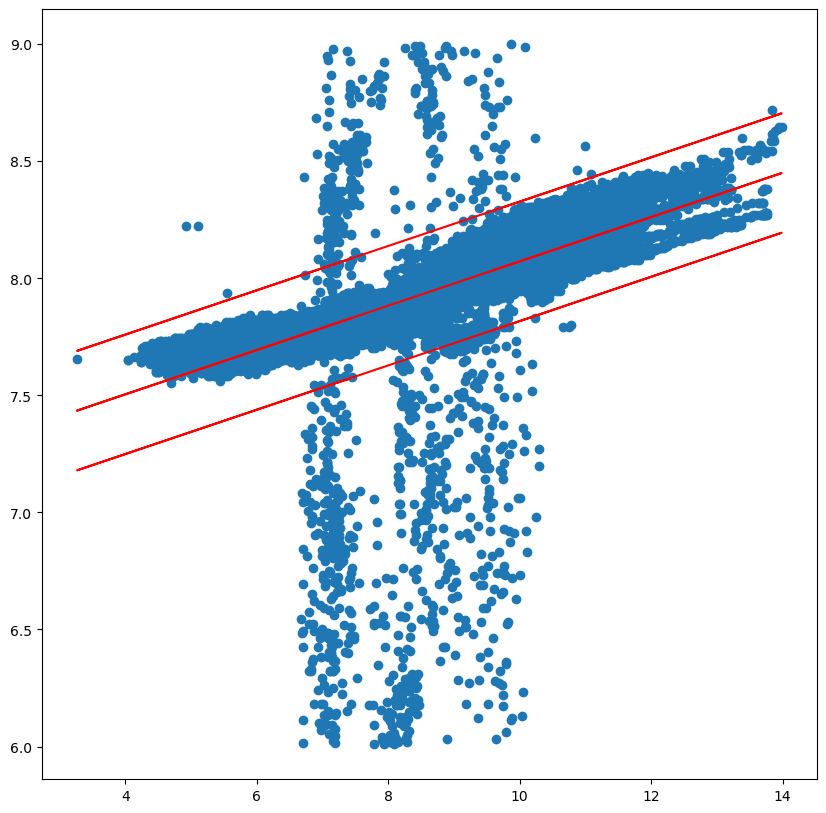

In [303]:
# LinearRegression requires reshaping of the data so this converts the pandas series to 
# a numpy array and then reshapes
x = andy['hydrocatDissOxygen'].to_numpy().reshape(-1, 1)
y = andy['pH total'].to_numpy().reshape(-1, 1)
model = LinearRegression().fit(x, y)
# linear model y predicted
y_pred = model.predict(x)
# new dataset
ANDY = andy
# add predicted pH
ANDY['y_pred'] = y_pred
# difference between predicted and actual
ANDY['y - y_pred'] = y - y_pred

fig, ax = plt.subplots(figsize = [10,10])

ax.scatter(x,y)
ax.plot(x,y_pred, color = 'red')
ax.plot(x,y_pred - andy['pH total'].std(), color = 'red')
ax.plot(x,y_pred + andy['pH total'].std(), color = 'red')

In [304]:
# for each row in ANDY
for ind in ANDY.index:
    # if the absolute value difference between the actual pH and the predicted pH
    # is larger than 1 standard deviation
    if np.abs(ANDY['y - y_pred'][ind]) > andy['pH total'].std():
        # drop that row
        ANDY = ANDY.drop(ind)
# reset the index
ANDY = ANDY.reset_index(drop=True)
ANDY

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total,y_pred,y - y_pred
0,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 09:31:15.400000,7.934479,8.033908,-0.099429
1,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 10:46:15.400000,7.934814,8.040631,-0.105817
2,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 11:01:15.200000,7.934773,8.037790,-0.103017
3,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 11:16:15.200000,7.934821,8.042241,-0.107420
4,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 11:31:15.200000,7.924688,8.043945,-0.119258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34891,2023-06-05T22:01:29.000Z,06/05/2023 22:00:00,16.2791,37.2464,7.151,28.9322,0.026,20.115,8.04,2023-06-05 22:01:29,7.913850,7.802774,0.111075
34892,2023-06-05T23:31:29.000Z,06/05/2023 23:30:00,16.1783,37.0774,7.208,28.8592,0.026,20.072,8.15,2023-06-05 23:31:29,8.023942,7.808172,0.215771
34893,2023-06-05T23:46:29.000Z,06/05/2023 23:45:00,16.2141,37.0341,7.226,28.7960,0.026,19.893,8.19,2023-06-05 23:46:29,8.063798,7.809876,0.253922
34894,2023-06-06T00:46:29.000Z,06/06/2023 00:45:00,16.2786,37.0104,7.180,28.7291,0.027,20.274,8.16,2023-06-06 00:46:29,8.033597,7.805520,0.228076


### Plot PLT davies buoy data, excluding data that do not show oxygen pH correlation

Text(0.5, 0, 'Year-Month')

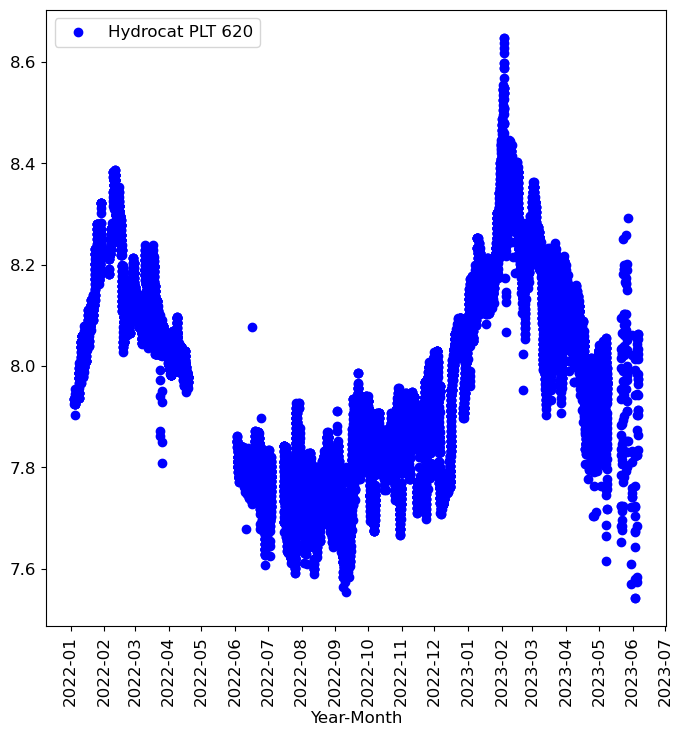

In [305]:
fig,ax = plt.subplots(figsize=[8,8])
ax.scatter(ANDY['DateTime'], ANDY['pH total'], color = 'blue', label = 'Hydrocat PLT 620')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

### This block of code just filters out rows in the GB buoy data that do NOT have oxygen or pH

In [296]:
for ind in andyGB.index:
    if math.isnan(andyGB['pH total'][ind]) or math.isnan(andyGB['hydrocatDissOxygen'][ind]):
        andyGB = andyGB.drop(ind)
andyGB = andyGB.reset_index(drop=True)
andy

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
0,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 09:31:15.400000,7.934479
1,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 10:46:15.400000,7.934814
2,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 11:01:15.200000,7.934773
3,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 11:16:15.200000,7.934821
4,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 11:31:15.200000,7.924688
...,...,...,...,...,...,...,...,...,...,...,...
36277,2023-06-06T22:46:29.000Z,06/06/2023 22:45:00,16.3779,37.4033,7.494,28.9958,0.007,19.400,8.66,2023-06-06 22:46:29,8.533749
36278,2023-06-06T23:01:29.000Z,06/06/2023 23:00:00,16.3461,37.3693,7.508,28.9896,0.006,19.625,8.65,2023-06-06 23:01:29,8.523799
36279,2023-06-06T23:16:29.000Z,06/06/2023 23:15:00,16.3289,37.3464,7.494,28.9823,0.005,19.891,8.53,2023-06-06 23:16:29,8.403822
36280,2023-06-06T23:31:29.000Z,06/06/2023 23:30:00,16.3370,37.3471,7.424,28.9770,0.005,19.804,8.59,2023-06-06 23:31:29,8.463800


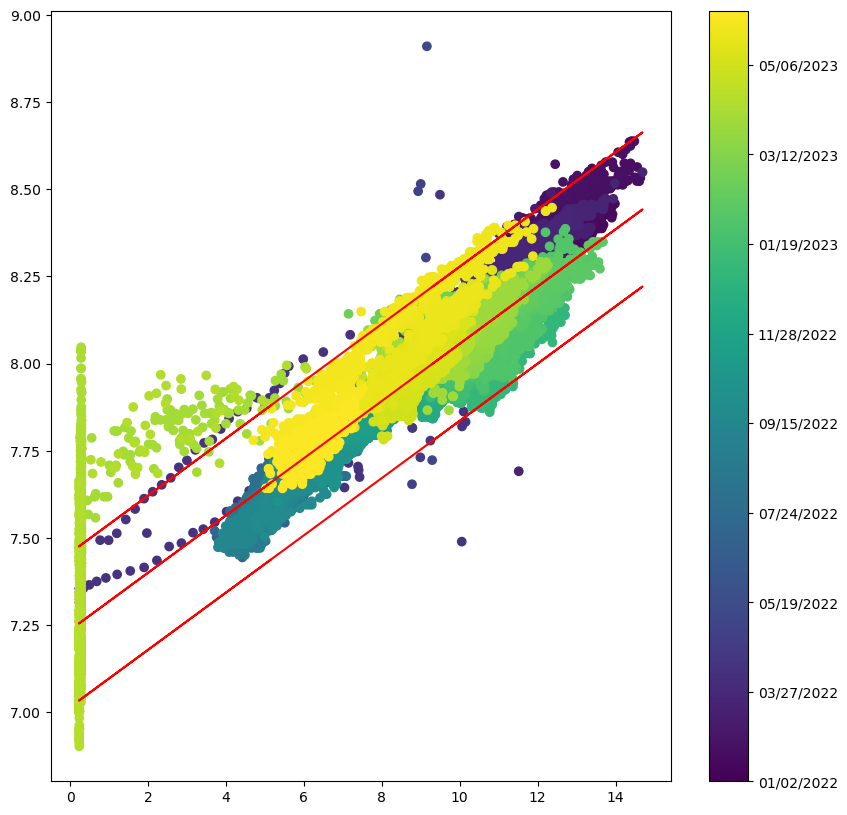

In [251]:
x = andyGB['hydrocatDissOxygen'].dropna().to_numpy().reshape(-1, 1)
y = andyGB['pH total'].dropna().to_numpy().reshape(-1, 1)
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
ANDYGB = andyGB
ANDYGB['y_pred'] = y_pred
ANDYGB['y - y_pred'] = y - y_pred

fig, ax = plt.subplots(figsize = [10,10])

cr = andyGB['DateTime'].map(pd.Series(data=np.arange(len(andyGB)), index=andyGB['DateTime'].values).to_dict())
im = ax.scatter(x,y, c=cr)
cbar = plt.colorbar(im, ax = ax, ticks = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000])
cbar.ax.set_yticklabels([andyGB['DateTime'][0].strftime('%m/%d/%Y'), andyGB['DateTime'][5000].strftime('%m/%d/%Y'), andyGB['DateTime'][10000].strftime('%m/%d/%Y'), 
                         andyGB['DateTime'][15000].strftime('%m/%d/%Y'), andyGB['DateTime'][20000].strftime('%m/%d/%Y'), 
                        andyGB['DateTime'][25000].strftime('%m/%d/%Y'), andyGB['DateTime'][30000].strftime('%m/%d/%Y'),
                        andyGB['DateTime'][35000].strftime('%m/%d/%Y'), andyGB['DateTime'][40000].strftime('%m/%d/%Y')])
ax.plot(x,y_pred, color = 'red')
ax.plot(x,y_pred - andyGB['pH total'].std(), color = 'red')
ax.plot(x,y_pred + andyGB['pH total'].std(), color = 'red')


In [298]:
andyGB['hydrocatDissOxygen'].min()

0.225